In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#files = [os.path.join(dirname, filename) for dirname, _, filenames in os.walk('/kaggle/input') for filename in filenames]

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

np.random.seed(31415)

In [2]:
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, classification_report, accuracy_score, f1_score, plot_confusion_matrix, balanced_accuracy_score
def print_precision_report(y_test,y_pred,x_test,model,labels,unique_classes,plotsize, colormap = False, model_name = ''):
    #getting metrics
    precision = precision_score(y_test, y_pred, average = 'macro')
    recall = recall_score(y_test, y_pred, average = 'macro')
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = 'macro')
    
    #ploting confusion matrix
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=plotsize, facecolor = 'white')
    ax.set_title(type(model).__name__)
    disp = plot_confusion_matrix(model, x_test, y_test,display_labels=labels,xticks_rotation=20,ax=ax, normalize='true')
    if not colormap:
        disp.im_.colorbar.remove()
    plt.margins(0.1)
    plt.savefig('{}-6Classes.png'.format(model_name),transparent = False, bbox_inches='tight')
    
    #ROC AUC
    y_test = label_binarize(y_test, classes=unique_classes)
    y_pred = label_binarize(y_pred, classes=unique_classes)
    roc_auc = roc_auc_score(y_test, y_pred, multi_class="ovr")
    
    #printing metrics
    print("Precisão:", precision)
    print("Recall/Revocação/Sensibilidade:", recall)    
    print("Acurácia:", accuracy)
    print("Acurácia Balanceada:",balanced_accuracy)
    print("Medida F1:", f1_score)
    print("Roc AUC:",roc_auc_score)
    
    return [model_name,precision,recall,accuracy,balanced_accuracy,f1,roc_auc]

In [3]:
df_raw = pd.read_csv(f'./processedFiles.csv')
print("Número de linhas e colunas no conjunto de treinamento:", df_raw.shape)
print("Número de linhas e colunas no conjunto de teste:", df_raw.shape)
attributes = list(df_raw.columns)
df_raw.head()

classes_label = {'normal':0,'imbalance':1,'overhang':2,'underhang':3,'vertical-misalignment':4,'horizontal-misalignment':5}
colors = ['blue','red','green','magenta','orange','cyan']

df_X = df_raw.drop(['Unnamed: 0','filePath','Class6','Class10'],axis = 1)
scaler = StandardScaler().fit(df_X)
X = scaler.transform(df_X)
Y = df_raw['Class6'].map(classes_label).to_numpy()
unique_classes = np.unique(Y)

df_X.head(10)

Número de linhas e colunas no conjunto de treinamento: (1951, 85)
Número de linhas e colunas no conjunto de teste: (1951, 85)


,Tachometer main frequency,Tachometer mean,Tachometer entropy,Tachometer kurtosis,Tachometer rms,Tachometer peak to peak,Tachometer shape indicator,Tachometer impulse indicator,Tachometer crest indicator,Tachometer clearance indicator,...,Microphone mean,Microphone entropy,Microphone kurtosis,Microphone rms,Microphone peak to peak,Microphone shape indicator,Microphone impulse indicator,Microphone crest indicator,Microphone clearance indicator,Microphone skewness
0,12.0,0.002930,2.155789,4.304473,1.585572,-6.2337,1.617277,5.209933,3.221424,6.496703,...,0.008016,1.818507,0.065309,0.112425,-0.77416,1.221686,5.872358,4.806766,6.752480,0.685550
1,12.8,0.005695,2.153490,4.168970,1.596103,-6.2125,1.609710,5.110197,3.174607,6.361800,...,0.007704,1.834837,0.241943,0.116036,-0.86253,1.228879,6.391702,5.201244,7.374075,0.740827
2,14.0,-0.003637,2.150613,4.138177,1.598855,-6.2670,1.595314,5.081820,3.185467,6.290660,...,0.017536,1.910258,0.063221,0.132987,-0.96741,1.236221,6.284034,5.083263,7.279235,0.694690
3,14.8,0.002550,2.149442,3.967702,1.612556,-6.3006,1.589255,5.000190,3.146247,6.185735,...,0.019339,1.919532,0.018246,0.135144,-0.96375,1.235200,6.260704,5.068577,7.249635,0.674586
4,15.8,0.004700,2.162512,3.813742,1.625237,-6.3730,1.579440,4.958330,3.139296,6.121404,...,0.014026,1.880101,-0.100899,0.125709,-0.83014,1.218678,5.577019,4.576287,6.405791,0.616928
5,16.8,-0.002639,2.163104,3.819209,1.624728,-6.4590,1.571273,4.906867,3.122861,6.037446,...,0.011380,1.874983,0.043660,0.124522,-0.87701,1.223577,6.005457,4.908114,6.914232,0.664931
6,18.0,-0.002509,2.152143,3.734698,1.631818,-6.3477,1.564022,4.843449,3.096791,5.945002,...,0.013102,1.885812,0.150725,0.127139,-0.91561,1.231728,6.152573,4.995076,7.109552,0.698158
7,19.2,0.000546,2.150201,3.595487,1.643699,-6.3302,1.555974,4.775935,3.069419,5.851070,...,0.013488,1.930206,0.135242,0.136813,-0.97410,1.231472,6.085748,4.941850,7.036395,0.696739
8,19.8,-0.000553,2.149882,3.570277,1.645932,-6.2874,1.552674,4.777075,3.076677,5.846183,...,0.013546,1.935647,0.180273,0.138068,-0.99201,1.233676,6.020773,4.880351,6.968443,0.708950
9,21.2,0.001392,2.151135,3.433023,1.658026,-6.3496,1.543289,4.693555,3.041268,5.730218,...,0.011827,1.929733,0.108563,0.136460,-0.94545,1.228972,5.832187,4.745583,6.736015,0.684121


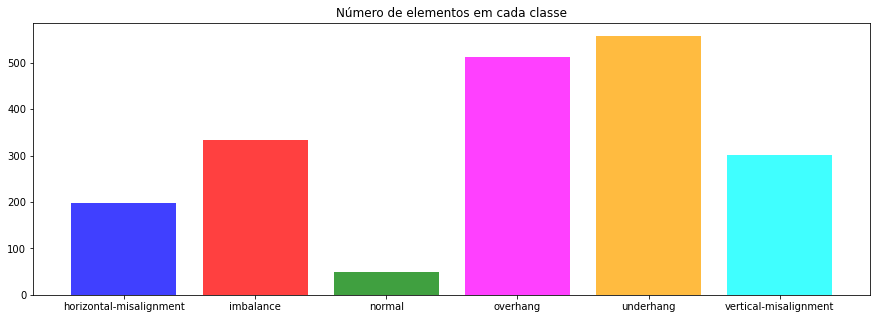

In [4]:
classes = df_raw['Class6']
cl = np.unique(classes)
ncl = np.zeros(len(cl))
for i in np.arange(0, len(cl)):
    a = classes == cl[i]
    ncl[i] = len(classes[a])
    
numbers = np.arange(0, len(cl))
plt.figure(figsize=(15,5))
plt.bar(numbers, ncl,  alpha=.75,color = colors)
plt.xticks(numbers, cl)
plt.title('Número de elementos em cada classe')
plt.show(True)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [7]:
param_grid = {'n_estimators': range(1,50,2),
             'class_weight': ['balanced'] }
base_estimator = RandomForestClassifier()
grid_RF = GridSearchCV(base_estimator, param_grid, cv=10, scoring = 'balanced_accuracy', verbose = 1, n_jobs = -1).fit(x_train, y_train)
# Return set of parameters with the best performances
print('Melhor modelo:', grid_RF.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_RF.best_score_)

model = grid_RF.best_estimator_
model.fit(x_train,y_train)
y_pred = model.predict(x_test) 

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Melhor modelo: {'class_weight': 'balanced', 'n_estimators': 27}
Melhor acurácia: 0.9586443347312912


Precisão: 0.9666582261694215
Recall/Revocação/Sensibilidade: 0.9300464701294556
Acurácia: 0.9641638225255973
Acurácia Balanceada: 0.9300464701294556
Medida F1: <function f1_score at 0x0000028481653310>
Roc AUC: <function roc_auc_score at 0x00000284816455E0>


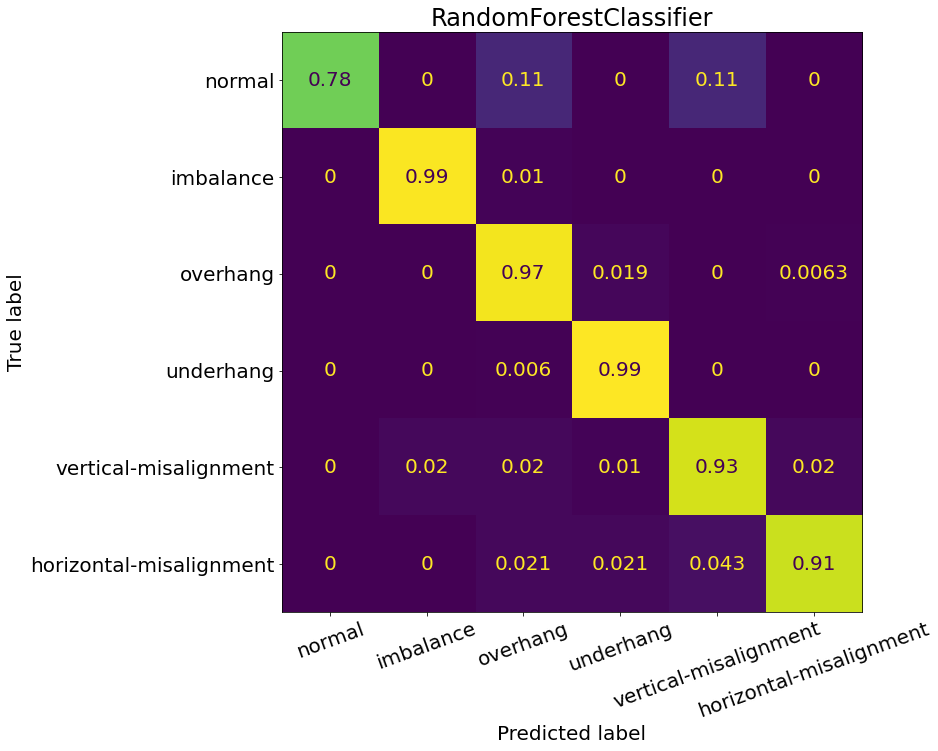

In [8]:
RandomForestMetrics = print_precision_report(y_test,y_pred,x_test,model,
                       labels = classes_label.keys(), 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'Random Forest')

In [ ]:
importances = model.feature_importances_
attributes = df_X.columns
indices = np.argsort(importances)
attributes_rank = []
for i in indices:
    attributes_rank.append(attributes[i])
fig, ax = plt.subplots(figsize=(15,40))
plt.title('Feature Importances')
plt.tight_layout()
ax.barh(range(len(indices)), importances[indices], color='b', align='center')

for i, v in enumerate(importances[indices]):
    ax.text(v , i , '{:.2f}%'.format(v*100), color='blue', fontweight='bold')

plt.yticks(range(len(indices)), attributes_rank, fontsize=25)
plt.xlabel('Relative Importance',fontsize=25)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show()

In [10]:
%%time
param_grid = {'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
base_estimator = SVC(gamma='scale')
grid_SVC = GridSearchCV(base_estimator, param_grid, cv=10, scoring = 'balanced_accuracy', verbose = 1, n_jobs = -1).fit(x_train, y_train)
# Return set of parameters with the best performances
print('Melhor modelo:', grid_SVC.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_SVC.best_score_)
model = grid_SVC.best_estimator_
y_pred = model.predict(x_test)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Melhor modelo: {'C': 10, 'kernel': 'rbf'}
Melhor acurácia: 0.9713427474297041
Wall time: 6 s


Precisão: 0.9650333186794593
Recall/Revocação/Sensibilidade: 0.9341389172430447
Acurácia: 0.962457337883959
Acurácia Balanceada: 0.9341389172430447
Medida F1: <function f1_score at 0x0000028481653310>
Roc AUC: <function roc_auc_score at 0x00000284816455E0>


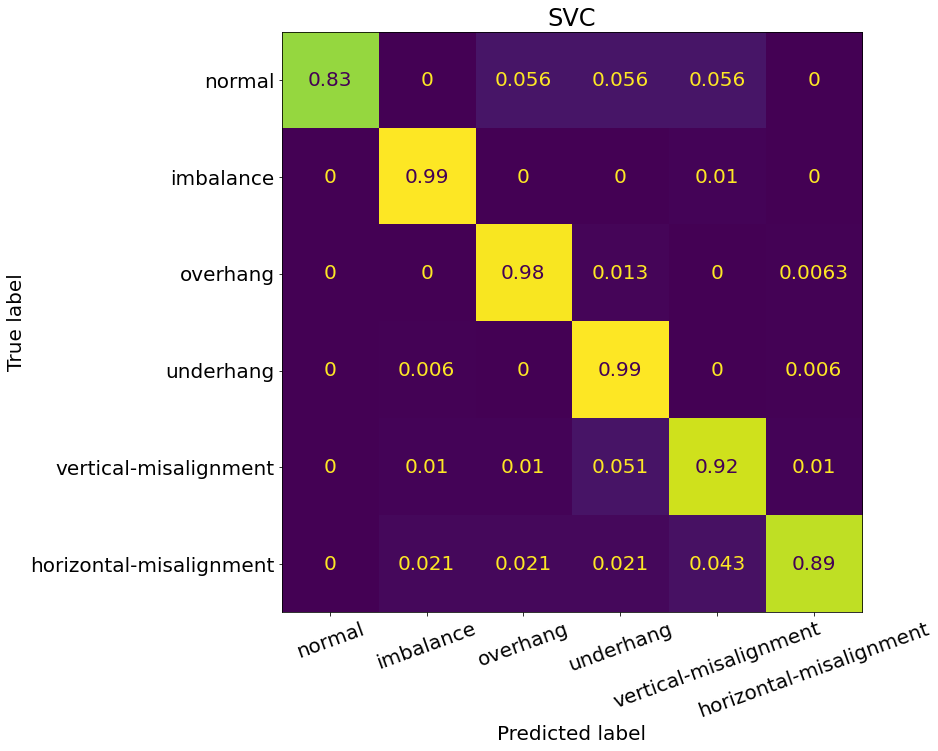

In [11]:
SVCMetrics = print_precision_report(y_test,y_pred,x_test,model,
                       labels = classes_label.keys(), 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'SVM')

In [15]:
%%time
from sklearn.neural_network import MLPClassifier

param_grid = {'solver': ['lbfgs'], 
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'max_iter': [1000, 1200, 1400], 
              'alpha': 10.0 ** -np.arange(1, 3), 
              'hidden_layer_sizes': [(10,10),(10,30),
                                     (20,10),(20,30),
                                     (30,10),(30,30)]}
base_estimator = MLPClassifier()
grid_MLPC = GridSearchCV(base_estimator, param_grid, cv = 10 scoring = 'balanced_accuracy', verbose = 1, n_jobs=-1,).fit(x_train, y_train)

# Return set of parameters with the best performances
print('Melhor modelo:', grid_MLPC.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_MLPC.best_score_)
model = grid_MLPC.best_estimator_
y_pred = model.predict(x_test)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Melhor modelo: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (30, 30), 'max_iter': 1200, 'solver': 'lbfgs'}
Melhor acurácia: 0.9790158257905048
Wall time: 2min 2s


Precisão: 0.9708774495897906
Recall/Revocação/Sensibilidade: 0.9583554045579362
Acurácia: 0.9761092150170648
Acurácia Balanceada: 0.9583554045579362
Medida F1: <function f1_score at 0x0000028481653310>
Roc AUC: <function roc_auc_score at 0x00000284816455E0>


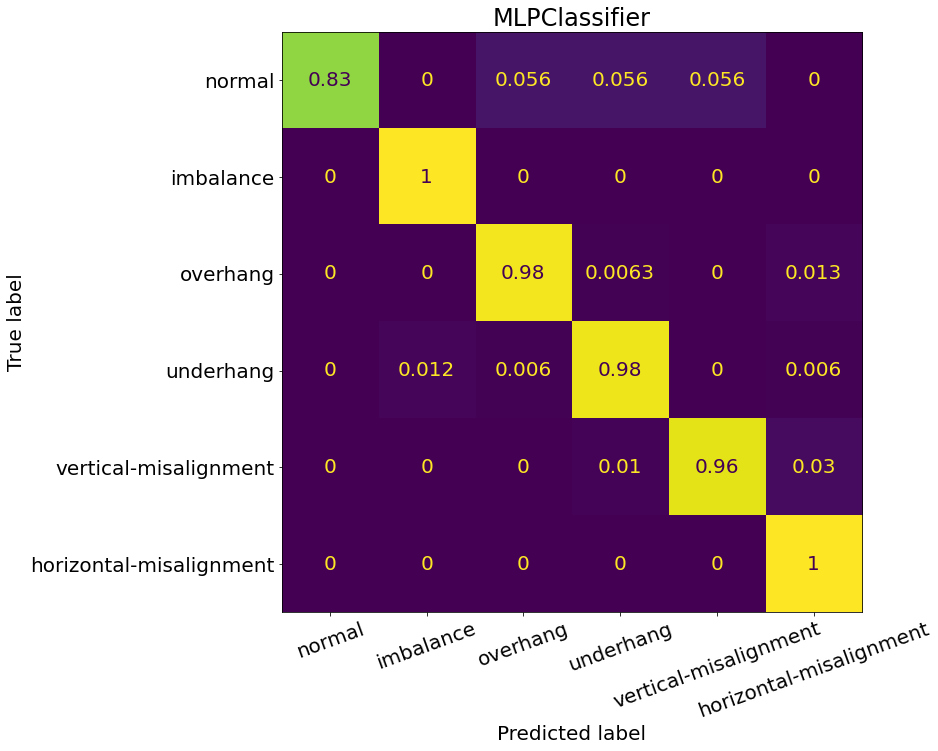

In [16]:
MLPMetrics = print_precision_report(y_test,y_pred,x_test,model,
                       labels = classes_label.keys(), 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'MLP')

In [17]:
results = pd.DataFrame([RandomForestMetrics,SVCMetrics,MLPMetrics], columns=['Modelo','Precisao','Recall','Acuracia','acuraciaBalanceada','FScore','ROCAUC']) 
results.set_index('Modelo', inplace = True)
results = results * 100
results.to_csv('6classesResults.csv',float_format='%.2f')
results.head()

,Precisao,Recall,Acuracia,acuraciaBalanceada,FScore,ROCAUC
Modelo,,,,,,
Random Forest,96.665823,93.004647,96.416382,93.004647,94.594118,96.117508
SVM,96.503332,93.413892,96.245734,93.413892,94.810047,96.303260
MLP,97.087745,95.835540,97.610922,95.835540,96.272868,97.675131


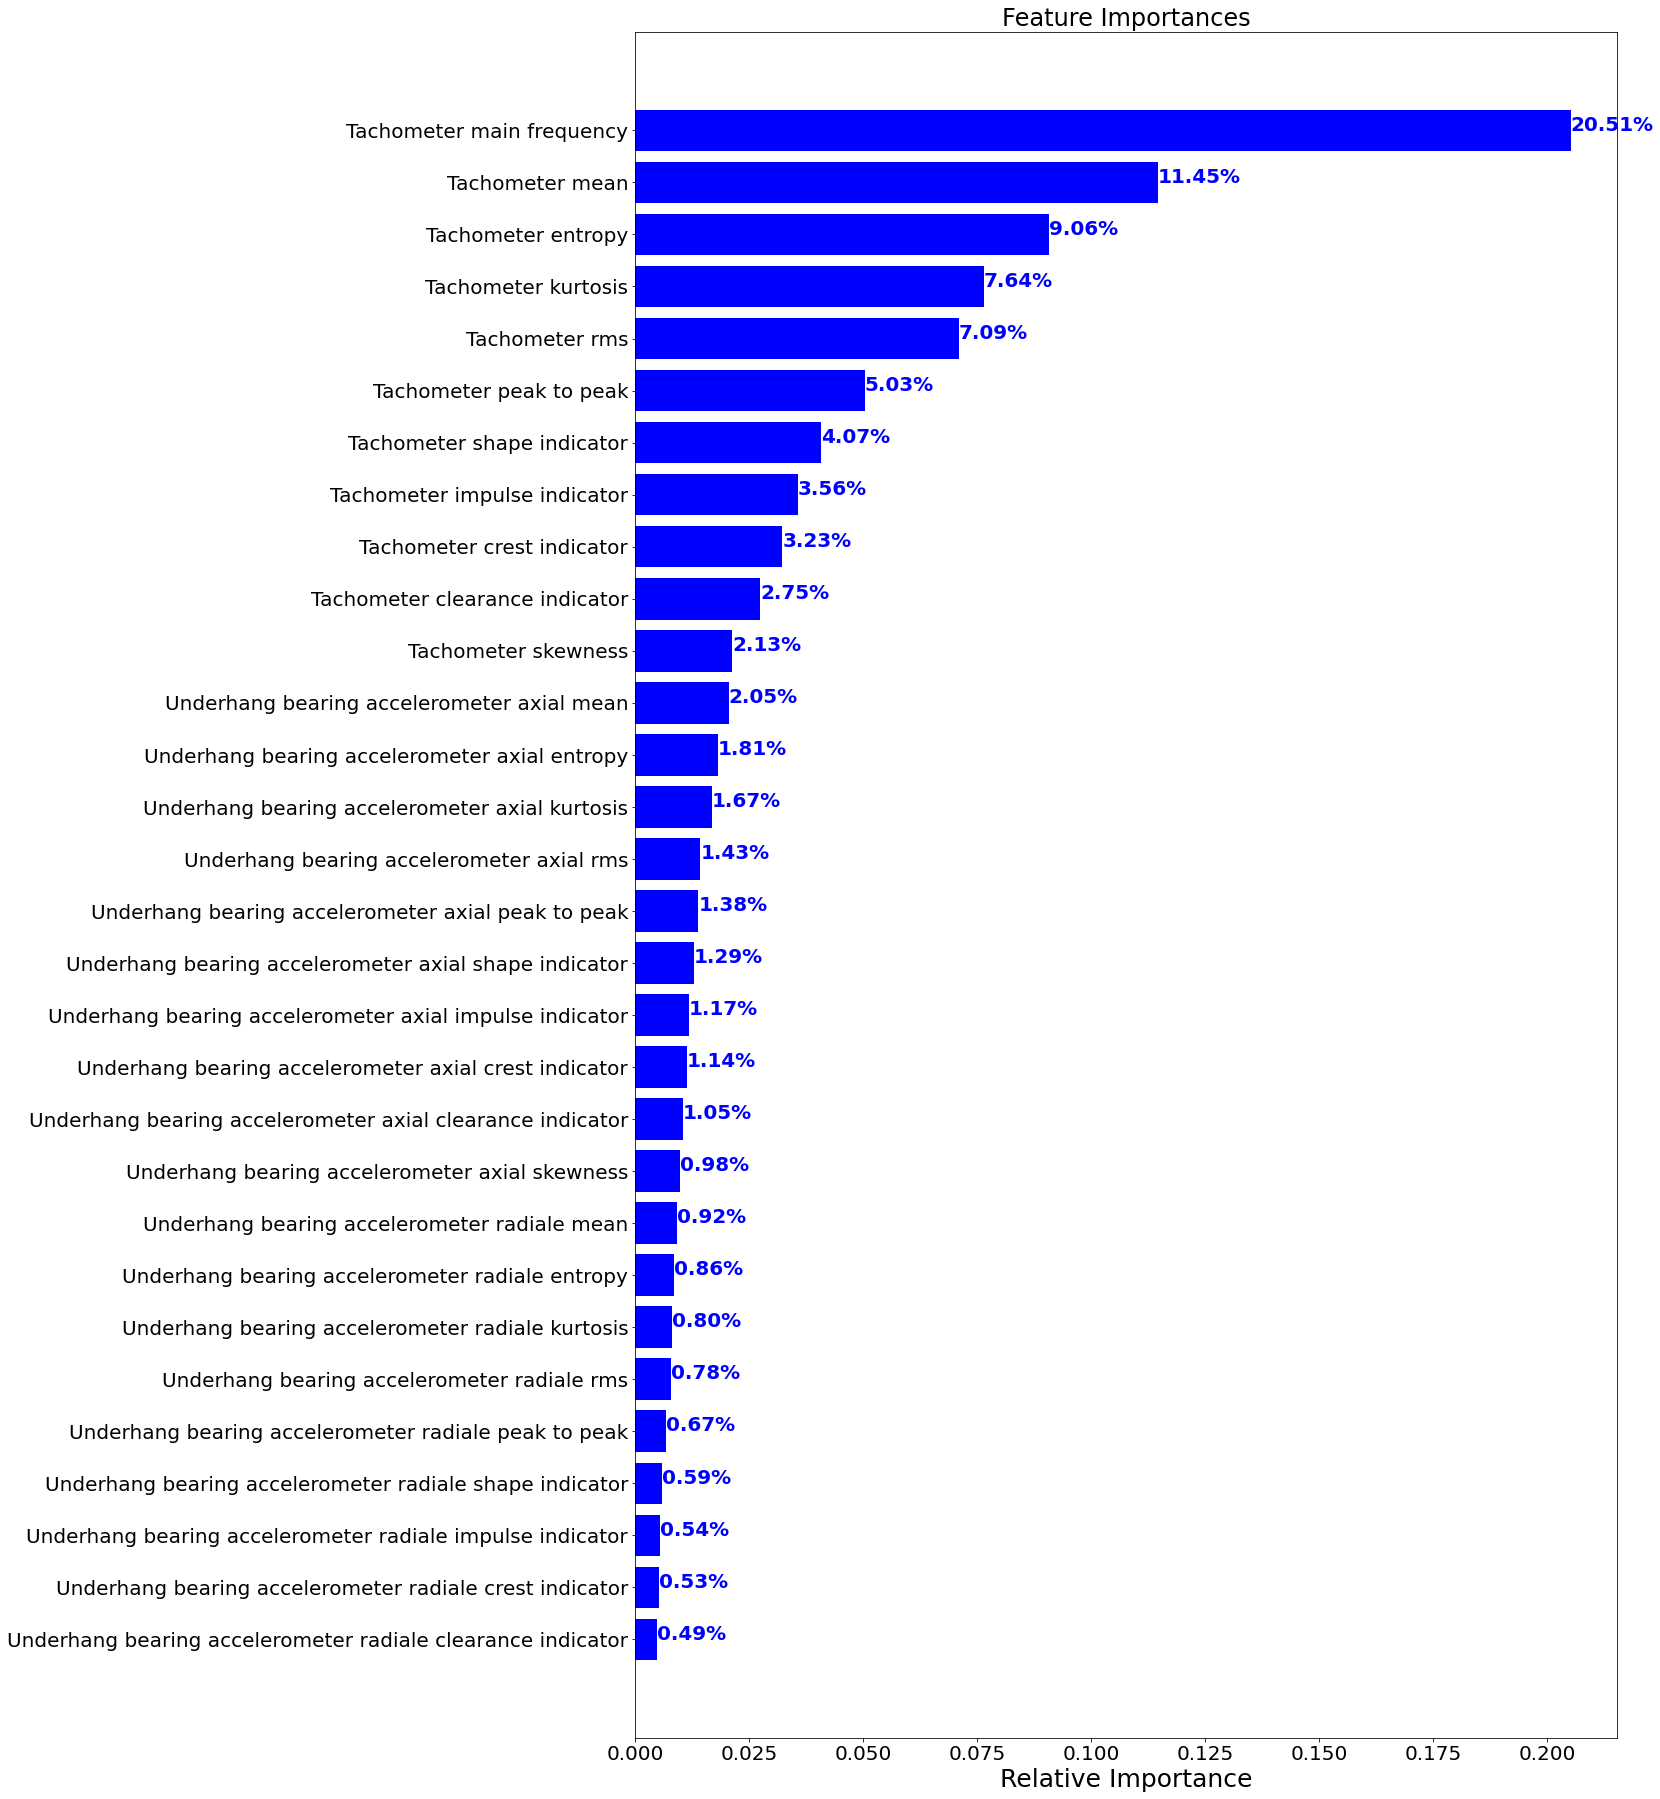

In [18]:
pca = PCA(n_components = 30)
pca_result = pca.fit_transform(X)
var_exp = pca.explained_variance_ratio_

importances = var_exp
attributes = df_X.columns
indices = np.argsort(importances)
attributes_rank = []
for i in indices:
    attributes_rank.append(attributes[i])
fig, ax = plt.subplots(figsize=(15,25))
plt.title('Feature Importances')
plt.tight_layout()
ax.barh(range(len(indices)), importances[indices], color='b', align='center')

for i, v in enumerate(importances[indices]):
    ax.text(v , i , '{:.2f}%'.format(v*100), color='blue', fontweight='bold')

plt.yticks(range(len(indices)), attributes_rank, fontsize=25)
plt.xlabel('Relative Importance',fontsize=25)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show()

In [19]:
pca_result_x_train, pca_result_x_test, y_train, y_test = train_test_split(pca_result, Y, test_size = 0.3)

In [20]:
%%time
param_grid = {'n_estimators': range(1,50,2),
             'class_weight': ['balanced'] }
base_estimator = RandomForestClassifier()
grid_RF = GridSearchCV(base_estimator, param_grid, cv=10, scoring = 'balanced_accuracy', verbose = 1, n_jobs = -1).fit(pca_result_x_train, y_train)
# Return set of parameters with the best performances
print('Melhor modelo:', grid_RF.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_RF.best_score_)

model = grid_RF.best_estimator_
model.fit(pca_result_x_train, y_train)
y_pred = model.predict(pca_result_x_test) 

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Melhor modelo: {'class_weight': 'balanced', 'n_estimators': 41}
Melhor acurácia: 0.815096062670294
Wall time: 16.7 s


Precisão: 0.8528423484189988
Recall/Revocação/Sensibilidade: 0.809424280272626
Acurácia: 0.8805460750853242
Acurácia Balanceada: 0.809424280272626
Medida F1: <function f1_score at 0x0000028481653310>
Roc AUC: <function roc_auc_score at 0x00000284816455E0>


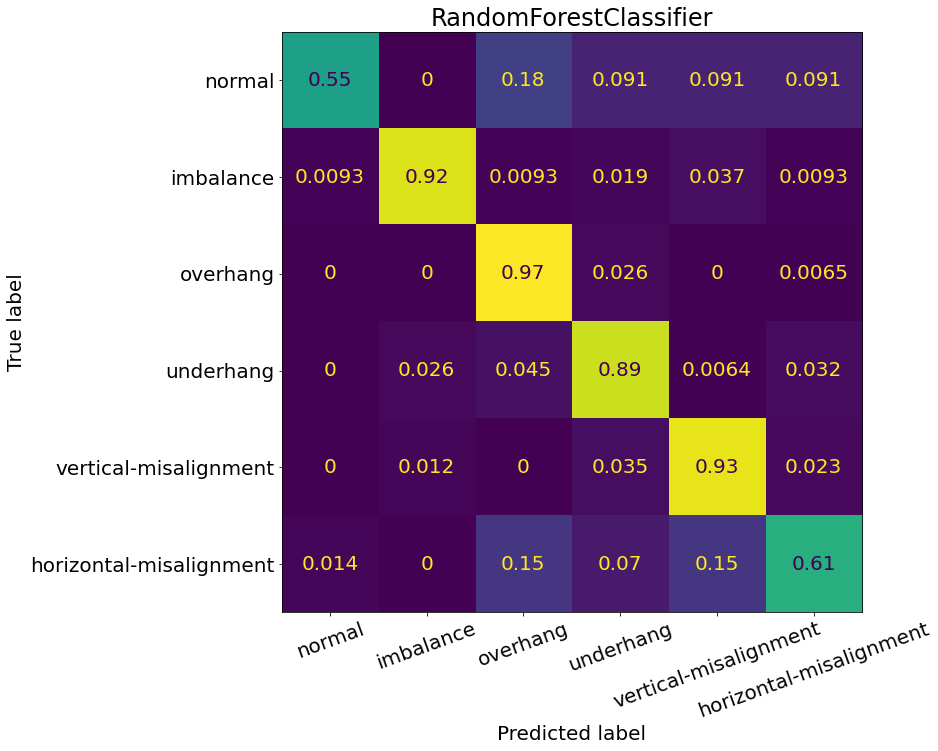

In [21]:
RandomForestMetrics = print_precision_report(y_test,y_pred,pca_result_x_test,model,
                       labels = classes_label.keys(), 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'Random Forest - PCA')

In [25]:
%%time
param_grid = {'C': [1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
base_estimator = SVC(gamma='scale')
grid_SVC = GridSearchCV(base_estimator, param_grid, cv=10, scoring = 'balanced_accuracy', verbose = 1, n_jobs = -1).fit(pca_result_x_train, y_train)
# Return set of parameters with the best performances
print('Melhor modelo:', grid_SVC.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_SVC.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor modelo: {'C': 100, 'kernel': 'rbf'}
Melhor acurácia: 0.9380334634337816
Wall time: 14.7 s


Precisão: 0.9565358708258564
Recall/Revocação/Sensibilidade: 0.9492252030056375
Acurácia: 0.9641638225255973
Acurácia Balanceada: 0.9492252030056375
Medida F1: <function f1_score at 0x0000028481653310>
Roc AUC: <function roc_auc_score at 0x00000284816455E0>


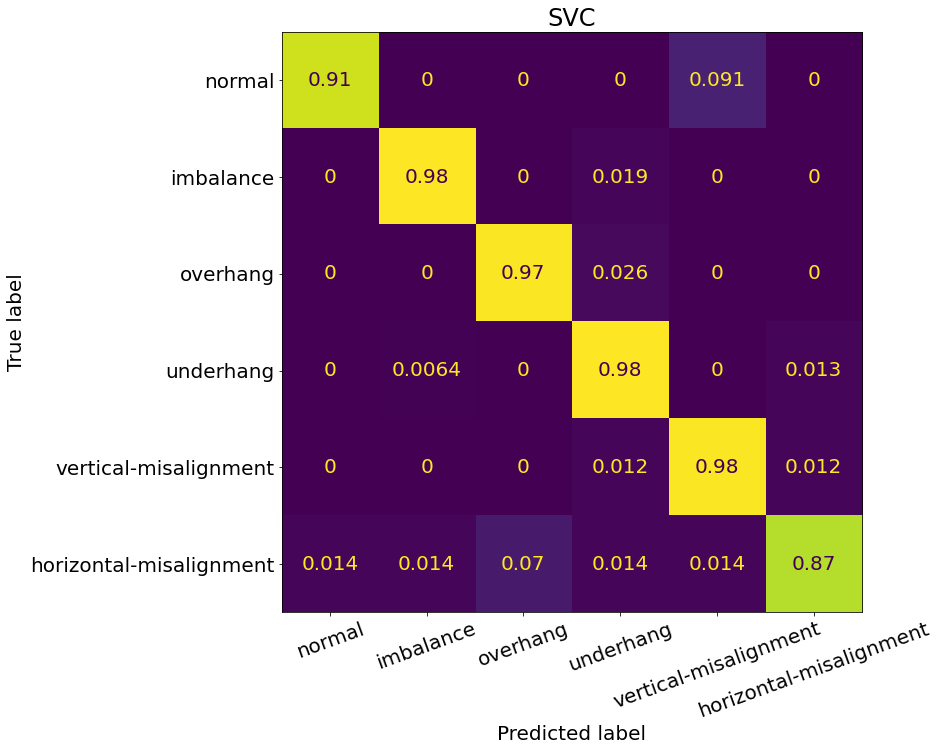

In [26]:
model = grid_SVC.best_estimator_
y_pred = model.predict(pca_result_x_test)
SVCMetrics = print_precision_report(y_test,y_pred,pca_result_x_test,model,
                       labels = classes_label.keys(), 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'SVC - PCA')

In [27]:
%%time
param_grid = {'solver': ['lbfgs'], 
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'max_iter': [1000, 1200, 1400], 
              'alpha': 10.0 ** -np.arange(1, 3), 
              'hidden_layer_sizes': [(10,10),(10,30),
                                     (20,10),(20,30),
                                     (30,10),(30,30)]}
base_estimator = MLPClassifier()
grid_RF = GridSearchCV(base_estimator, param_grid, cv=10, scoring = 'balanced_accuracy', verbose = 2, n_jobs=-1).fit(pca_result_x_train, y_train)
# Return set of parameters with the best performances
print('Melhor modelo:', grid_MLPC.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_MLPC.best_score_)

model = grid_MLPC.best_estimator_
model.fit(pca_result_x_train,y_train)
y_pred = model.predict(pca_result_x_test) 

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Melhor modelo: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (30, 30), 'max_iter': 1200, 'solver': 'lbfgs'}
Melhor acurácia: 0.9790158257905048


Precisão: 0.978768440574378
Recall/Revocação/Sensibilidade: 0.9667671289982679
Acurácia: 0.9778156996587031
Acurácia Balanceada: 0.9667671289982679
Medida F1: <function f1_score at 0x0000028481653310>
Roc AUC: <function roc_auc_score at 0x00000284816455E0>


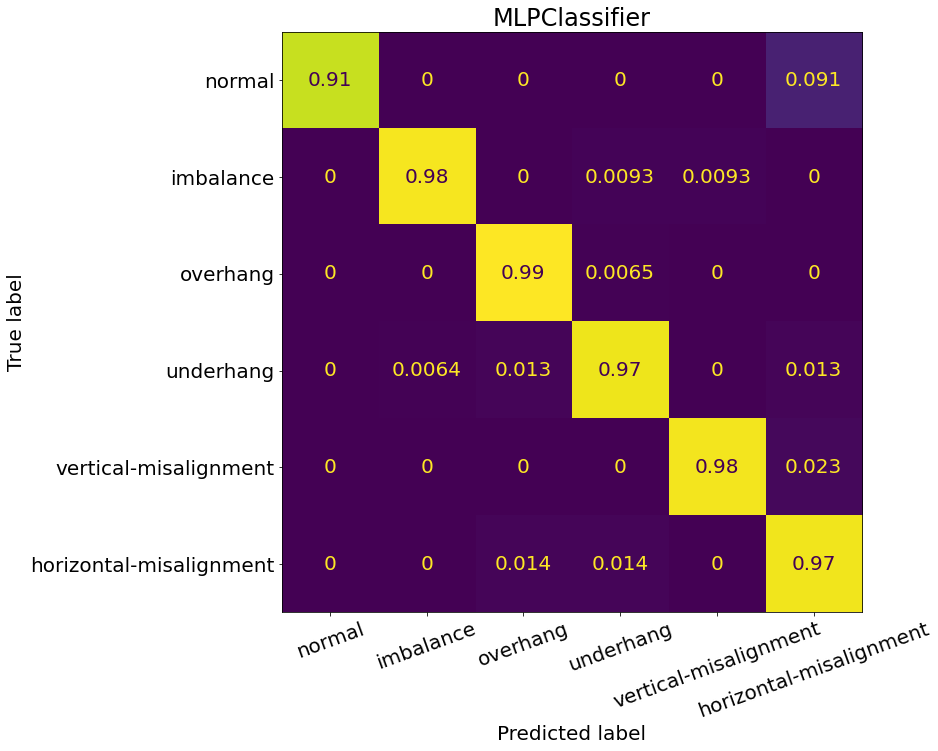

In [29]:
MLPMetrics = print_precision_report(y_test,y_pred,pca_result_x_test,model,
                       labels = classes_label.keys(), 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'MLP - PCA')

In [30]:
results = pd.DataFrame([RandomForestMetrics,SVCMetrics,MLPMetrics], columns=['Modelo','Precisao','Recall','Acuracia','acuraciaBalanceada','FScore','ROCAUC']) 
results.set_index('Modelo', inplace = True)
results = results * 100
results.to_csv('6classesPCAResults.csv',float_format='%.2f')
results.head()

,Precisao,Recall,Acuracia,acuraciaBalanceada,FScore,ROCAUC
Modelo,,,,,,
Random Forest - PCA,85.284235,80.942428,88.054608,80.942428,82.498897,89.214124
SVC - PCA,95.653587,94.922520,96.416382,94.922520,95.254246,97.078533
MLP - PCA,97.876844,96.676713,97.781570,96.676713,97.231634,98.107340
